In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import re
import numpy as np
import os
from glob import glob
ORIG_DATA_DIR = "../input/kitti-road-dataset/data_road"
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [12]:
DATA_DIR = "../data/"
MODEL_DIR = "../model/"
NUM_CLASSES = 2
DROPOUT = 0.5
INPUT_SHAPE = tf.keras.Input((125,414,3))

FCN-based network: Use a encoder, freeze the weights, and expand via using an decoder. Train the decoder using transfer learning)

FCN 8: Take the scalings from 7th, 4th as well as 3rd block

In [13]:
def fcn_8():
    with strategy.scope():
        model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
                                            pooling=None, classes=1000, classifier_activation='softmax')
        model.trainable = False
        inp_0 = model.layers[0]

        tensor = inp_0(INPUT_SHAPE)
        imp_tensor_index = [10, 14, 18]
        imp_tensor = [tensor]

        count = 1
        for layer in model.layers[1:]:
            tensor = layer(tensor)
            if count in imp_tensor_index:
                imp_tensor.append(tensor)
            count+=1
        inp_layer, layer_3, layer_4, layer_5 = imp_tensor


        fcn_8_from_layer_7 = tf.keras.layers.Conv2D(4096,(7,7), padding='same',
                                                    activation = "relu",name = "block6_conv1")(layer_5)

        fcn_8_from_layer_7 = tf.keras.layers.Dropout(DROPOUT, 
                                                     name = "block6_dropout1")(fcn_8_from_layer_7)

        fcn_8_from_layer_7 = tf.keras.layers.Conv2D(4096,(1,1),activation = "relu",
                                                    name = "block7_conv1")(fcn_8_from_layer_7)

        fcn_8_from_layer_7 = tf.keras.layers.Dropout(DROPOUT,
                                                     name = "block7_dropout1")(fcn_8_from_layer_7)

        fcn_8_from_layer_7 = tf.keras.layers.Conv2D(NUM_CLASSES,(1,1),activation = "relu",
                                                    name = "fcn_layer_7")(fcn_8_from_layer_7)

        #Upsample 1
        fcn_8_from_layer_7 = tf.keras.layers.Conv2DTranspose(layer_4.shape.as_list()[-1],4,(2,2))(fcn_8_from_layer_7)
        fcn_8_from_layer_7 = tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))(fcn_8_from_layer_7)
        layer_4_plus_layer_7 = tf.keras.layers.Add()([fcn_8_from_layer_7,layer_4])

        #Upsample 2
        layer_4_upsampled = tf.keras.layers.Conv2DTranspose(layer_3.shape.as_list()[-1],4,(2,2))(layer_4_plus_layer_7)
        layer_4_upsampled = tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))(layer_4_upsampled)
        layer_3_plus_layer_4 = tf.keras.layers.Add()([layer_4_upsampled,layer_3])

        #Upsample 3
        fcn_8 = tf.keras.layers.Conv2DTranspose(NUM_CLASSES,16,(8,8))(layer_3_plus_layer_4)
        fcn_8 = tf.keras.layers.Cropping2D(cropping=((2, 1), (1, 1)))(fcn_8)
        
        fcn_model = tf.keras.Model(inputs=INPUT_SHAPE, outputs=fcn_8)
        return fcn_model

FCN 32 : Upsample directly from the 7th block | Expectation: More "blocky" images

In [14]:
def fcn_32():
    model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
                                            pooling=None, classes=1000, classifier_activation='softmax')
    model.trainable = False
    inp_0 = model.layers[0]

    tensor = inp_0(INPUT_SHAPE)
    imp_tensor_index = [10, 14, 18]
    imp_tensor = [tensor]

    count = 1
    for layer in model.layers[1:]:
        tensor = layer(tensor)
        if count in imp_tensor_index:
            imp_tensor.append(tensor)
        count+=1
    inp_layer, layer_3, layer_4, layer_5 = imp_tensor


    fcn_32_from_layer_7 = tf.keras.layers.Conv2D(4096,(7,7), padding='same',
                                                activation = "relu",name = "block6_conv1")(layer_5)

    fcn_32_from_layer_7 = tf.keras.layers.Dropout(DROPOUT, 
                                                 name = "block6_dropout1")(fcn_32_from_layer_7)

    fcn_32_from_layer_7 = tf.keras.layers.Conv2D(4096,(1,1),activation = "relu",padding='same',
                                                name = "block7_conv1")(fcn_32_from_layer_7)

    fcn_32_from_layer_7 = tf.keras.layers.Dropout(DROPOUT,
                                                 name = "block7_dropout1")(fcn_32_from_layer_7)

    fcn_32_from_layer_7 = tf.keras.layers.Conv2D(NUM_CLASSES,(1,1),activation = "relu",padding="same",
                                                name = "fcn_layer_7")(fcn_32_from_layer_7)

    #Upsample 1
    print(fcn_32_from_layer_7.shape)

    fcn_32 = tf.keras.layers.Conv2DTranspose(NUM_CLASSES,64,(42,35),padding="same")(fcn_32_from_layer_7)
    fcn_32 = tf.keras.layers.Cropping2D(cropping=((1, 0), (3, 3)))(fcn_32)
    fcn_model = tf.keras.Model(inputs=INPUT_SHAPE, outputs=fcn_32)
    return fcn_model

FCN 16: Take up upsampling from 4th block and 7th block. Expectation : Less blocky from the 2n d

In [15]:
def fcn_16():
    model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
                                    pooling=None, classes=1000, classifier_activation='softmax')
    model.trainable = False
    inp_0 = model.layers[0]

    tensor = inp_0(INPUT_SHAPE)
    imp_tensor_index = [10, 14, 18]
    imp_tensor = [tensor]

    count = 1
    for layer in model.layers[1:]:
        tensor = layer(tensor)
        if count in imp_tensor_index:
            imp_tensor.append(tensor)
        count+=1
    inp_layer, layer_3, layer_4, layer_5 = imp_tensor


    fcn_8_from_layer_7 = tf.keras.layers.Conv2D(4096,(7,7), padding='same',
                                                activation = "relu",name = "block6_conv1")(layer_5)

    fcn_8_from_layer_7 = tf.keras.layers.Dropout(DROPOUT, 
                                                 name = "block6_dropout1")(fcn_8_from_layer_7)

    fcn_8_from_layer_7 = tf.keras.layers.Conv2D(4096,(1,1),activation = "relu",
                                                name = "block7_conv1")(fcn_8_from_layer_7)

    fcn_8_from_layer_7 = tf.keras.layers.Dropout(DROPOUT,
                                                 name = "block7_dropout1")(fcn_8_from_layer_7)

    fcn_8_from_layer_7 = tf.keras.layers.Conv2D(NUM_CLASSES,(1,1),activation = "relu",
                                                name = "fcn_layer_7")(fcn_8_from_layer_7)

    #Upsample 1
    fcn_8_from_layer_7 = tf.keras.layers.Conv2DTranspose(layer_4.shape.as_list()[-1],4,(2,2))(fcn_8_from_layer_7)
    fcn_8_from_layer_7 = tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))(fcn_8_from_layer_7)
    layer_4_plus_layer_7 = tf.keras.layers.Add()([fcn_8_from_layer_7,layer_4])

    #Upsample 2
    layer_4_upsampled = tf.keras.layers.Conv2DTranspose(2,16,(18,17))(layer_4_plus_layer_7)
    fcn_16 = tf.keras.layers.Cropping2D(cropping=((1, 0), (6, 5)))(layer_4_upsampled)
    fcn_model = tf.keras.Model(inputs=INPUT_SHAPE, outputs=fcn_16)

    return fcn_model

In [ ]:
def data_preprocessing_and_load(image_shape,dataset_type = "training"):

    data_folder = os.path.join(ORIG_DATA_DIR, dataset_type)
    # save_folder = os.path.join(POST_PROCESSING_DATA_DIR, dataset_type)

    image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
    label_paths = {
        re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
        for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
    background_color = np.array([1, 0, 0], dtype=np.float32)
    count = 0
    # save_img = os.path.join(save_folder,"image_2")
    # save_gt = os.path.join(save_folder,"gt_image_2")
    # os.makedirs(save_img,exist_ok=True)
    # os.makedirs(save_gt,exist_ok = True)
    lhs = []
    rhs = []
    
    lhrh = []

    for image_path in image_paths:

        gt_image_file = label_paths[os.path.basename(image_path)]

        image_import = Image.open(image_path)
        gt_image_import = Image.open(gt_image_file)
        image_import = image_import.resize(image_shape,Image.BICUBIC)
        gt_image_import = gt_image_import.resize(image_shape,Image.BICUBIC)


        image = np.array(image_import, dtype = np.float32) / 255
        gt_image = np.array(gt_image_import, dtype = np.float32) / 255

        # One-hot labels
        gt_bg = np.all(gt_image == background_color, axis=2)
        gt_bg = gt_bg.reshape(*gt_bg.shape, 1)

        gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)
        gt_image = gt_image.astype('float32')
        # image_path = os.path.join(save_img, "{}.png".format(str(count_image)) )
        # gt_image_path = os.path.join(save_gt,"{}.png".format(str(count_image)))
#         lhs.append(image)
#         rhs.append(gt_image)
        lhrh.append((image, gt_image))
#         lhs.append(np.flip(image,1))
#         rhs.append(np.flip(gt_image,1))
        lhrh.append((np.flip(image,1), np.flip(gt_image,1)))
        count+=1

#     shuffle(lhrh)
    for lr in lhrh:
        lhs.append(lr[0])
        rhs.append(lr[1])
    
    lhs=np.stack(lhs)
    rhs=np.stack(rhs)
    return lhs, rhs
        
X, Y = data_preprocessing_and_load((414, 125))
print(len(X))

In [ ]:
print(X.shape, X[0].shape)
print(Y[0].shape, Y[1].shape)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2)

# X_train = X[:-len(X)//5]
# Y_train = Y[:-len(Y)//5]
# X_valid = X[-len(X)//5:]
# Y_valid = Y[-len(Y)//5:]
print(len(X_train), len(X_valid))

FCN 8 Training

In [ ]:
from tensorflow.keras.optimizers import Nadam
with strategy.scope():
    fcn_model = fcn_8()
    print(fcn_model.summary())
    fcn_model.compile(optimizer = Nadam(lr=0.001), loss = 'binary_crossentropy')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,LearningRateScheduler
from math import floor,pow
model_name = 'fcn_8.h5'
def step_lr(epoch):
   init_lr = 0.00005
   drop = 0.5
   epoch_step =  25
   new_lr = init_lr * pow(drop,floor((1+epoch)/epoch_step))
   return new_lr
step_learning_rate = LearningRateScheduler(step_lr)
# early stopping should always be the last callback
stopper = EarlyStopping(monitor='loss', patience=10)
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss', mode='min', save_best_only=True)

# fcn_model.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy')

if os.path.isfile(model_name):
    print('Loaded saved Model!')
    fcn_model.load_weights(model_name)




In [ ]:
losses = list()
val_losses = list()

In [ ]:
history = fcn_model.fit(
    X_train, Y_train,
    batch_size = 10 * strategy.num_replicas_in_sync,
#     batch_size = 16,
    epochs = 200,
    validation_data = (X_valid, Y_valid),
    callbacks = [checkpointer, stopper,step_learning_rate],
    shuffle = True,
    verbose = 1
)

losses += list(history.history['loss'])
val_losses += list(history.history['val_loss'])

In [ ]:
plt.plot(losses)
plt.plot(val_losses)
plt.show()

In [ ]:
fcn_model.save('entire_model.h5')

FCN 16 Training

In [ ]:
from tensorflow.keras.optimizers import Nadam
with strategy.scope():
    fcn_model = fcn_16()
    fcn_model.compile(optimizer = Nadam(lr=0.001), loss = 'binary_crossentropy')

In [ ]:
fcn_model.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,LearningRateScheduler
from math import floor,pow
model_name = 'fcn_16.h5'
def step_lr(epoch):
   init_lr = 0.0001
   drop = 0.5
   epoch_step =  25
   new_lr = init_lr * pow(drop,floor((1+epoch)/epoch_step))
   return new_lr
step_learning_rate = LearningRateScheduler(step_lr)
# early stopping should always be the last callback
stopper = EarlyStopping(monitor='loss', patience=10)
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss', mode='min', save_best_only=True)

# fcn_model.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy')

if os.path.isfile(model_name):
    print('Loaded saved Model!')
    fcn_model.load_weights(model_name)


In [ ]:
losses = list()
val_losses = list()

In [ ]:

history = fcn_model.fit(
    X_train, Y_train,
    batch_size = 10 * strategy.num_replicas_in_sync,
#     batch_size = 16,
    epochs = 200,
    validation_data = (X_valid, Y_valid),
    callbacks = [checkpointer, stopper,step_learning_rate],
    shuffle = True,
    verbose = 1
)

losses += list(history.history['loss'])
val_losses += list(history.history['val_loss'])

In [ ]:
plt.plot(losses)
plt.plot(val_losses)
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Nadam
with strategy.scope():
    fcn_model = fcn_32()
    fcn_model.compile(optimizer = Nadam(lr=0.001), loss = 'binary_crossentropy')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,LearningRateScheduler
from math import floor,pow
model_name = 'fcn_32.h5'
def step_lr(epoch):
   init_lr = 0.001
   drop = 0.5
   epoch_step =  10
   new_lr = init_lr * pow(drop,floor((1+epoch)/epoch_step))
   return new_lr
step_learning_rate = LearningRateScheduler(step_lr)
# early stopping should always be the last callback
stopper = EarlyStopping(monitor='loss', patience=10)
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss', mode='min', save_best_only=True)

# fcn_model.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy')

if os.path.isfile(model_name):
    print('Loaded saved Model!')
    fcn_model.load_weights(model_name)


In [ ]:
losses = list()
val_losses = list()

In [ ]:

history = fcn_model.fit(
    X_train, Y_train,
    batch_size = 10 * strategy.num_replicas_in_sync,
#     batch_size = 16,
    epochs = 200,
    validation_data = (X_valid, Y_valid),
    callbacks = [checkpointer, stopper,step_learning_rate],
    shuffle = True,
    verbose = 1
)

losses += list(history.history['loss'])
val_losses += list(history.history['val_loss'])

In [8]:
def generate_output(image,gt_np_array):
    image = image*255
    print(image.shape)
    image = image.astype('uint8')
    gt_road = gt_np_array[:,:,1]
    gt_not_road = gt_np_array[:,:,0]
    mask_bits = np.zeros(gt_road.shape)
    mask_bits[gt_road > gt_not_road] = 1
    green = np.asarray([0,255,0,127])
    mask = np.outer(mask_bits,green).reshape(mask_bits.shape[0],-1,len(green))
    mask = mask.astype('uint8')
    mask = Image.fromarray(mask)
    image = Image.fromarray(image)
    image.paste(mask,mask = mask)
    image = np.array(image)
    return image


In [9]:
def test_data(image_shape):
    dataset_type = "testing"
    data_folder = os.path.join(ORIG_DATA_DIR, dataset_type)
    # save_folder = os.path.join(POST_PROCESSING_DATA_DIR, dataset_type)

    image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
    
    background_color = np.array([1, 0, 0], dtype=np.float32)
    count = 0
    # save_img = os.path.join(save_folder,"image_2")
    # save_gt = os.path.join(save_folder,"gt_image_2")
    # os.makedirs(save_img,exist_ok=True)
    # os.makedirs(save_gt,exist_ok = True)
    lhs = []
    

    for image_path in image_paths:
        image_import = Image.open(image_path)
        image_import = image_import.resize(image_shape,Image.BICUBIC)
        image = np.array(image_import, dtype = np.float32) / 255
        
        lhs.append(image)
    
    lhs=np.stack(lhs)
    return lhs


FCN 8 Results

In [6]:
fcn_model = fcn_8()
fcn_model.load_weights("../input/fcn8weights/fcn_8 (1)/fcn_8 (1).h5")

58892288/58889256 [==============================] - 1s 0us/step


In [16]:
x_test = test_data((414, 125))
print("Prediction on test data")
results = fcn_model.predict(x_test)


Prediction on test data


(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)


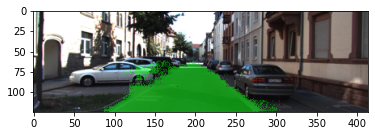

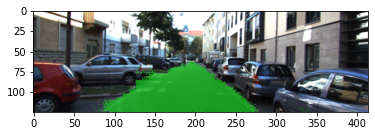

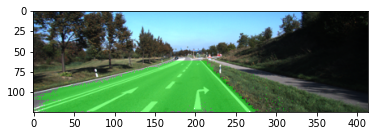

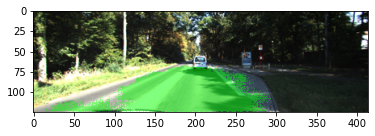

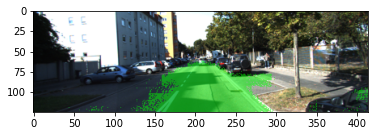

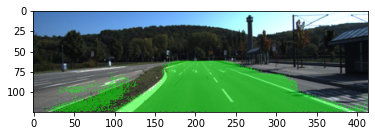

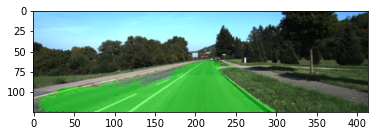

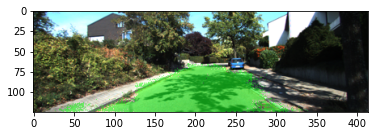

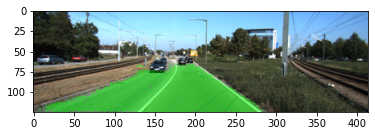

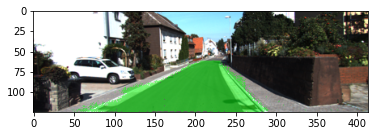

In [17]:
for i in range(10):
    plt.figure()
    plt.imshow(generate_output(x_test[i],results[i]))

FCN 16 Results

In [18]:
fcn_model = fcn_16()
fcn_model.load_weights("../input/fcn8weights/fcn_16.h5")

In [19]:
x_test = test_data((414, 125))
print("Prediction on test data")
results = fcn_model.predict(x_test)

Prediction on test data


(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)


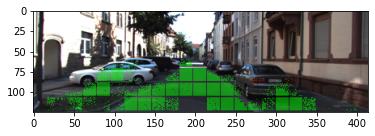

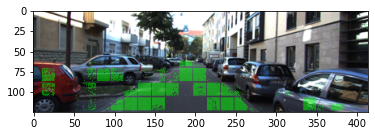

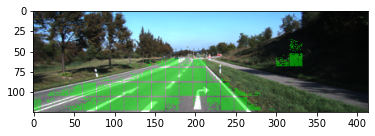

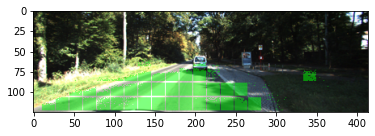

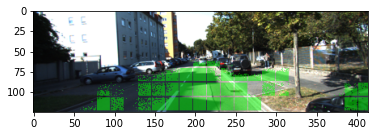

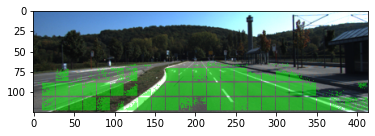

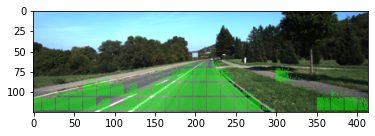

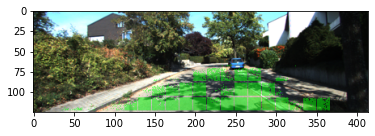

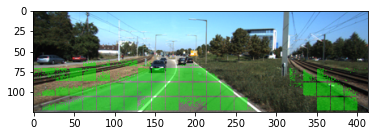

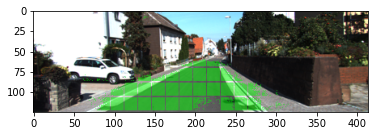

In [20]:
for i in range(10):
    plt.figure()

    plt.imshow(generate_output(x_test[i],results[i]))


FCN 32 Results

In [21]:
fcn_model = fcn_32()
fcn_model.load_weights("../input/fcn8weights/fcn_32.h5")

(None, 3, 12, 2)


In [22]:
print("Prediction on test data")
results = fcn_model.predict(x_test)

Prediction on test data


(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)
(125, 414, 3)


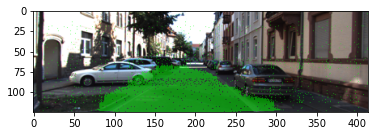

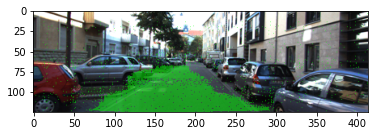

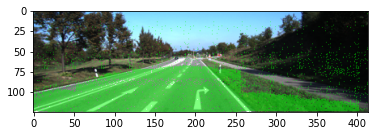

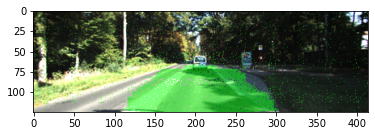

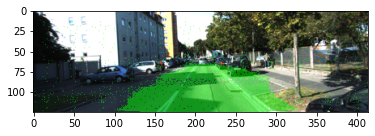

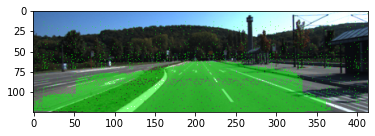

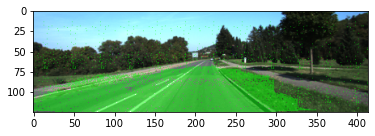

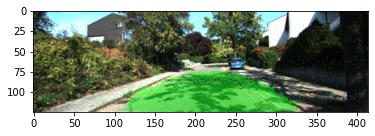

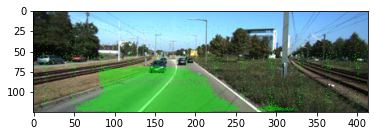

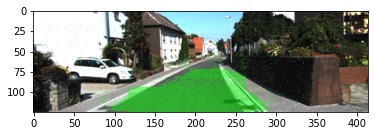

In [23]:
for i in range(10):
    plt.figure()

    plt.imshow(generate_output(x_test[i],results[i]))